In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install -U imbalanced-learn
!pip install scipy

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (19.1)
Requirement already up-to-date: imbalanced-learn in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (0.4.3)


In [48]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import random
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# ----------- TODO: Issues with importing imbalance-learn library
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import (RandomUnderSampler,
#                                      ClusterCentroids,
#                                      TomekLinks,
#                                      NeighbourhoodCleaningRule,
#                                      NearMiss)

In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, ForeignKey, Float
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")

In [10]:
class GetData(object):
    def go(self, SESSION, start_year, end_year):
        SQL_QUERY = \
            f'''
                WITH
                    max_severity AS (
                        SELECT MAX(severity) AS severity
                        FROM (
                            SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                            GROUP BY
                                incident.blockid,
                                incident.year,
                                incident.month,
                                incident.dow,
                                incident.hour
                        ) AS categories
                    ),
                    block_incidents AS (
                        SELECT
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            incident.hour,
                            SUM(crimetype.severity)/AVG(block.population) AS severity
                        FROM incident
                        INNER JOIN block ON incident.blockid = block.id
                        INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                            AND block.population > 0
                            AND incident.cityid = 1
                            AND incident.year >= {start_year}
                            AND incident.year <= {end_year}
                        GROUP BY
                            incident.blockid,
                            incident.year,
                            incident.month,
                            incident.dow,
                            incident.hour
                    )
                SELECT
                    block_incidents.blockid,
                    block_incidents.year,
                    block_incidents.month,
                    block_incidents.dow,
                    block_incidents.hour,
                    block_incidents.severity / max_severity.severity AS severity
                FROM block_incidents, max_severity        
            '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [23]:
def process_data(data, training_start_year, testing_start_year):

    NUM_BLOCKIDS = 20
    
    X = np.zeros((NUM_BLOCKIDS, 24, 7*24))
    y = np.zeros((NUM_BLOCKIDS, 12, 7*24))
    blockid_dict = {}

    # Create random array (BLOCKIDS) from 1-801 inclusive
    # of length NUM_BLOCKIDS
    BLOCKIDS = random.choices(list(range(1,802)), k=NUM_BLOCKIDS)
    
    for ind, blockid in enumerate(BLOCKIDS):
        blockid_dict[blockid] = ind

    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12
    
    for r in data:
        if r[0] in blockid_dict:
            if r[1] == testing_start_year:
                # index into array  0-based month
                # vvvvvvvvvvvvvvvv    vvvvvv
                y[blockid_dict[r[0]], r[2]-1, 24*r[3]+r[4]] = r[5]
                #                             ^^^^^^^^^^^^^   ^^^^
                #                             hours since     risk
                #                             beginning of
                #                             week
            else:
                # index into array    year 0.....1   month   
                # vvvvvvvvvvvvvvvv    vvvvvvvvvvvvv  vvvvvv
                X[blockid_dict[r[0]], 12*(r[1]-training_start_year)+r[2]-1, 24*r[3]+r[4]] = r[5]
                #                                                           ^^^^^^^^^^^^^   ^^^^
                #                                                           hours since     risk
                #                                                           beginning of
                #                                                           week                

        # All neural networks require floating point data.
        # The scaler converts ints to floats.
        # We use the RobustScaler since it keeps the data
        # more spread out than the StandardScaler.
        # Check out the figures here:
        # https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
#         X = RobustScaler().fit_transform(X)

#         print('\n', X[:10], '\n')
#         print('\n', y.head(), '\n')

    return X, y

In [24]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year,
               testing_start_year, testing_end_year):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        testing_start_year)
        X_test, y_test = process_data(testing_data,
                                        training_start_year, 
                                        testing_start_year)

    return X_train, X_test, y_train, y_test

In [25]:
%%time
X_train, X_test, y_train, y_test = ready_data(2016, 2017, 2018, 2018)

CPU times: user 1.23 s, sys: 251 ms, total: 1.48 s
Wall time: 58 s


In [26]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20, 24, 168), (20, 12, 168), (20, 24, 168), (20, 12, 168))

In [30]:
X_train[:, 0, 0]

array([0.        , 0.        , 0.00020794, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00031974, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

## Predictions

In [54]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape

data_dim    = 7 * 24   # All values in each hour of the week
timesteps   = 2 * 12   # Summed per month
batch_size  = 64
num_outputs = 7 * 24 * 12

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32.
model.add(Dense(num_outputs, activation='relu'))         # Leaky-ReLU and ReLU are the same for Keras
model.add(Reshape((12, 7 * 24)))

model.compile(loss='mean_squared_error',
              optimizer='adam')

model.fit(X_train, y_train,
          batch_size=batch_size, epochs=5,
          validation_data=(X_test, y_test))

mse = model.evaluate(X_test, y_test,
                     batch_size=batch_size)
print('Test MSE:', mse)

Train on 20 samples, validate on 20 samples
Epoch 1/5
20/20 [==============================] - 2s 121ms/step - loss: 7.4289e-11 - val_loss: 1.6767e-08
Epoch 2/5
20/20 [==============================] - 0s 3ms/step - loss: 4.1640e-11 - val_loss: 1.6697e-08
Epoch 3/5
20/20 [==============================] - 0s 3ms/step - loss: 2.8940e-11 - val_loss: 1.6678e-08
Epoch 4/5
20/20 [==============================] - 0s 3ms/step - loss: 2.3013e-11 - val_loss: 1.6696e-08
Epoch 5/5
20/20 [==============================] - 0s 1ms/step
Test MSE: 1.673609162367029e-08


In [59]:
min(y_train.flatten()), max(y_train.flatten())

(0.0, 0.0)

In [60]:
min(y_test.flatten()), max(y_test.flatten())

(0.0, 0.001968503937007874)

In [56]:
y_train_pred = model.predict(X_train).flatten()
min(y_train_pred), max(y_train_pred)

(0.0, 4.0000443e-05)

In [57]:
y_test_pred = model.predict(X_test).flatten()
min(y_test_pred), max(y_test_pred)

(0.0, 2.3218212e-05)

In [65]:
min(y_train.flatten() - y_train_pred.flatten()), max(y_train.flatten() - y_train_pred.flatten())

(-4.000044282292947e-05, 0.0)

([array([0., 9., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([10.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])],
 array([-4.00004428e+03, -3.24398541e+01,  3.93516457e+03,  7.90276900e+03,
         1.18703734e+04,  1.58379779e+04,  1.98055823e+04,  2.37731867e+04,
         2.77407911e+04,  3.17083956e+04,  3.56760000e+04]),
 <a list of 2 Lists of Patches objects>)

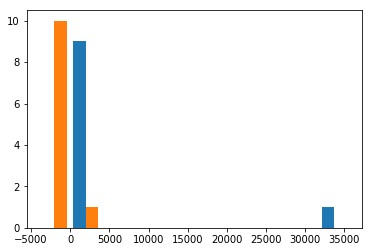

In [67]:
h = np.histogram((y_train - model.predict(X_train)).flatten() * 1e08)
plt.hist(h)

([array([9., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 2.])],
 array([ -2321.82119362,  17571.83089524,  37465.4829841 ,  57359.13507296,
         77252.78716181,  97146.43925067, 117040.09133953, 136933.74342839,
        156827.39551725, 176721.04760611, 196614.69969496]),
 <a list of 2 Lists of Patches objects>)

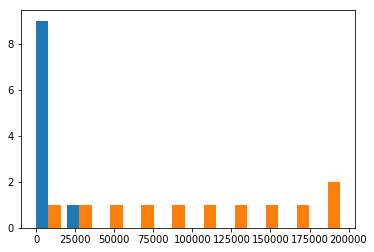

In [68]:
h = np.histogram((y_test - model.predict(X_test)).flatten() * 1e08)
plt.hist(h)